# Notebook analisando os dados eleitorais do segundo turno das eleições presidenciais brasileiras de 2022. 

Tirado do site brazilwasstolen.com.  Não sei de onde esses dados vieram, mas para refutar o sujeito apropriadamente resolvi utilizar o mesmo dataset

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
sns.set_theme()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


Primeiro criando umas variáveis de interesse

In [2]:
data=pd.read_csv('VOTOS_T1E2b.zip')
data['porc lula']=data['T2QT13']/(data['T2QT13']+data['T2QT22']) #Porcentagem de votos válidos para Lula, 2 turno
data['turnout']=(data['T2QTVAL']+data['T2QTBCO'])/data['QT_APTOS'] #turnout/comparecimento, 2 turno
data['urna 2020']=0
data.loc[data['LOG_MODELO']=='UE2020','urna 2020']=1 #quais usam urnas antigas, para facilitar comparações


# Análise geográfica

Dados eleitorais são tem correlação espacial bem forte, então ver como eles são distribuídos é essencial em qualquer análise

In [3]:
gp2=data.groupby(by=['LOG_MODELO'])
media_urna=gp2.mean()
mediana_urna=gp2.median()
print(media_urna.loc[:,['FG_CAPITAL', 'FG_METRO',  'QT_APTOS']])
print(mediana_urna.loc[:,[ 'QT_APTOS']])


            FG_CAPITAL  FG_METRO    QT_APTOS
LOG_MODELO                                  
-             0.116827  0.293384  331.956251
UE2009        0.056314  0.221907  326.425678
UE2010        0.063984  0.195026  318.919009
UE2011        0.071896  0.175939  315.233720
UE2013        0.063979  0.122115  316.947254
UE2015        0.091489  0.221827  323.482809
UE2020        0.408390  0.654166  346.187208
            QT_APTOS
LOG_MODELO          
-              338.0
UE2009         332.0
UE2010         331.0
UE2011         328.0
UE2013         326.0
UE2015         335.0
UE2020         352.0


A UE2020 está desproporcionalmente presente nas capitais e na região metropolitana comparado as outras urnas. Curiosamente ela também possui seções com mais eleitores

In [4]:
v,n_urnas=np.unique(data['LOG_MODELO'],return_counts=True)
porc_urnas=n_urnas/sum(n_urnas)

tot_municipio=np.unique(data['CD_MUNICIPIO']).shape[0]
n_municipio={}
for i in np.unique(data['LOG_MODELO']):
    zonas=data.loc[data['LOG_MODELO']==i,:]
    temp=np.unique(zonas['CD_MUNICIPIO'])
    n_municipio[i]=[temp.shape[0],temp.shape[0]/tot_municipio]
n_mun=pd.DataFrame(n_municipio,index=['Municipios com a urna presente',' Porc dos municipios com a urna presente']).T
df_urnas=pd.DataFrame(porc_urnas,index=v,columns=['Porc das urnas utilizadas'])
n_mun=n_mun.merge(df_urnas,left_index=True,right_index=True)
print(n_mun)

        Municipios com a urna presente  \
-                               2867.0   
UE2009                          1644.0   
UE2010                          2193.0   
UE2011                          1051.0   
UE2013                          1046.0   
UE2015                          2033.0   
UE2020                          1238.0   

         Porc dos municipios com a urna presente  Porc das urnas utilizadas  
-                                       0.502190                   0.021742  
UE2009                                  0.287966                   0.091116  
UE2010                                  0.384130                   0.194324  
UE2011                                  0.184095                   0.056281  
UE2013                                  0.183219                   0.051491  
UE2015                                  0.356104                   0.179738  
UE2020                                  0.216851                   0.405309  


Apesar de ser 40% das urnas utilizadas o modelo UE2020 se encontra em apenas 22% dos municípios, enquanto os outros modelos se mostram mais distribuídos. Isso demonstra o quão concentrado estão essas urnas e demonstra que a suposição de amostra independente é invalida

A seguir investigo a tal distribuição diferente dos votos para lula da urna UE2020 comparado com as outras urnas, seguido do turnout

<AxesSubplot:xlabel='turnout', ylabel='Density'>

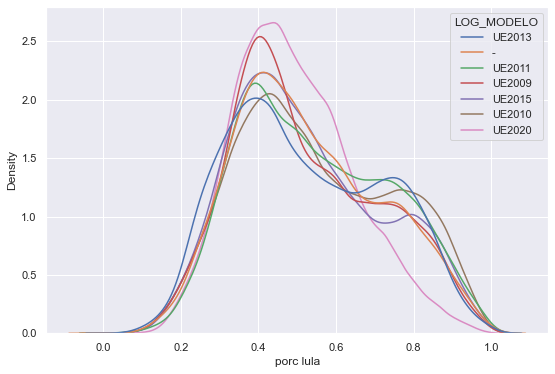

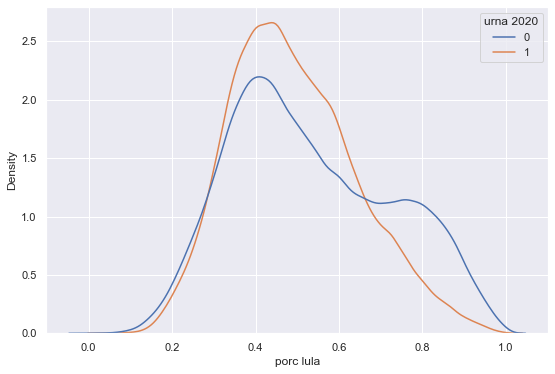

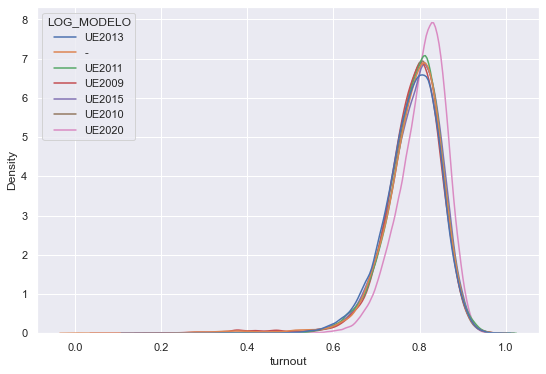

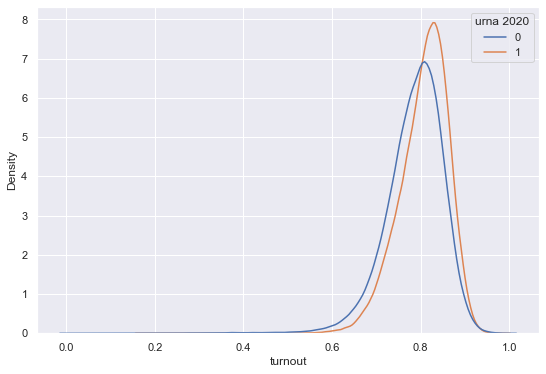

In [ ]:
plt.figure(figsize=(9,6))
sns.kdeplot(data=data,x='porc lula',hue='LOG_MODELO',common_norm=False)
plt.figure(figsize=(9,6))
sns.kdeplot(data=data,x='porc lula',hue='urna 2020',common_norm=False)
plt.figure(figsize=(9,6))
sns.kdeplot(data=data,x='turnout',hue='LOG_MODELO',common_norm=False)
plt.figure(figsize=(9,6))
sns.kdeplot(data=data,x='turnout',hue='urna 2020',common_norm=False)


Realmente o padrão de votação e comparecimento parecem diferentes, mas quando comparamos esse resultado estratificado por zona metropolitana os padrões se tornam parecidos

Text(0.5, 1.0, 'Distribuição do turnout, por região metropolitana')

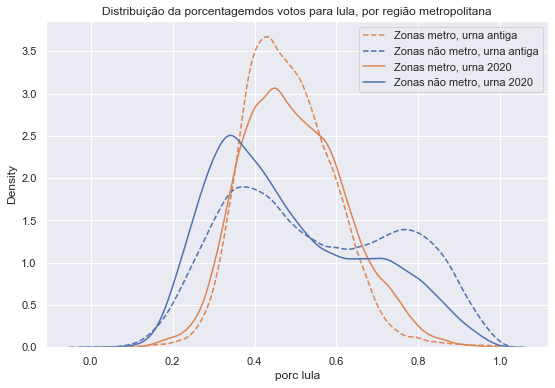

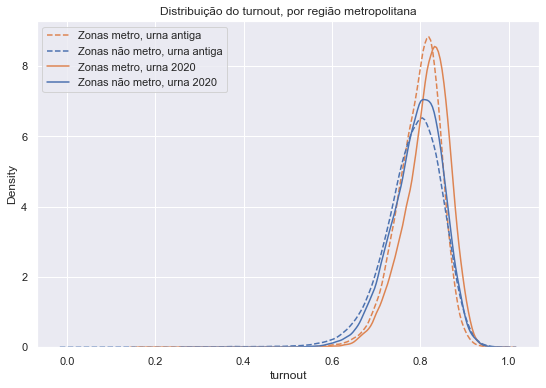

In [ ]:
data_urna_antiga=data.loc[np.logical_not(data['urna 2020'])]
data_urna_nova=data.loc[data['urna 2020']==1]


plt.figure(figsize=(9,6))
sns.kdeplot(data=data_urna_antiga,x='porc lula',hue='FG_METRO',common_norm=False, linestyle="--")

sns.kdeplot(data=data_urna_nova,x='porc lula',hue='FG_METRO',common_norm=False)
plt.title('Distribuição da porcentagemdos votos para lula, por região metropolitana')
plt.legend(['Zonas metro, urna antiga','Zonas não metro, urna antiga',
            'Zonas metro, urna 2020','Zonas não metro, urna 2020'])

plt.figure(figsize=(9,6))
sns.kdeplot(data=data_urna_antiga,x='turnout',hue='FG_METRO',common_norm=False, linestyle="--")
sns.kdeplot(data=data_urna_nova,x='turnout',hue='FG_METRO',common_norm=False)
plt.legend(['Zonas metro, urna antiga','Zonas não metro, urna antiga',
            'Zonas metro, urna 2020','Zonas não metro, urna 2020'])
plt.title('Distribuição do turnout, por região metropolitana')



O comportamento dos votos e do turnout é bem parecido entre as urnas quando separado por zona metropolitana. A suposta diferença entre ambas a distribuição é devido a maior concentração das urnas UE2020 em regiões metropolitanas. Quando se adiciona a concentração da urna UE2020 em poucos municípios fica claro que é uma diferença razoável.

Inclusive nas regiões metropolitanas as urnas UE2020 deram mais votos a Lula do que as urnas antigas

In [ ]:
lula_metro_antiga=data_urna_antiga.loc[data_urna_antiga['FG_METRO']==1,'porc lula'].mean()*100
lula_metro_nova=data_urna_nova.loc[data_urna_nova['FG_METRO']==1,'porc lula'].mean()*100

print('Nas zonas metropolitanas as urnas antigas deram ao Lula em média {:.3}% do voto, \nenquanto as urnas novas deram {:.3} %'.format(lula_metro_antiga,lula_metro_nova))

Nas zonas metropolitanas as urnas antigas deram ao Lula em média 48.4% do voto, 
enquanto as urnas novas deram 49.7 %


Adicionalmente, avaliando a divergência KL das distribuições podemos ver claramente que a diferença entre elas é mais forte na comparação rural/urbano que na comparação urna 2020/antiga

In [ ]:
from scipy.stats import gaussian_kde
from scipy.stats import entropy


kde_metro_nova=gaussian_kde(data_urna_nova.loc[data_urna_nova['FG_METRO']==1,'porc lula'])
kde_rural_nova=gaussian_kde(data_urna_nova.loc[data_urna_nova['FG_METRO']==0,'porc lula'])
kde_metro_antiga=gaussian_kde(data_urna_antiga.loc[data_urna_antiga['FG_METRO']==1,'porc lula'])
kde_rural_antiga=gaussian_kde(data_urna_antiga.loc[data_urna_antiga['FG_METRO']==0,'porc lula'])

x_kde=np.linspace(0,1,endpoint=True)
prob_metro_nova=kde_metro_nova.evaluate(x_kde)
prob_rural_nova=kde_rural_nova.evaluate(x_kde)
prob_metro_antiga=kde_metro_antiga.evaluate(x_kde)
prob_rural_antiga=kde_rural_antiga.evaluate(x_kde)



KL_metro_nova_antiga=(entropy(prob_metro_nova,prob_metro_antiga)+entropy(prob_metro_antiga,prob_metro_nova))/2
KL_rural_nova_antiga=(entropy(prob_rural_nova,prob_rural_antiga)+entropy(prob_rural_antiga,prob_rural_nova))/2
KL_metro_rural_nova=(entropy(prob_metro_nova,prob_rural_nova)+entropy(prob_rural_nova,prob_metro_nova))/2
KL_metro_rural_antiga=(entropy(prob_metro_nova,prob_rural_antiga)+entropy(prob_rural_nova,prob_metro_antiga))/2

print('Divergência entre as urnas 2020 e antigas na zona metropolitana = {:.3}'.format(KL_metro_nova_antiga))
print('Divergência entre as urnas 2020 e antigas na zona rural = {:.3}'.format(KL_rural_nova_antiga))
print('Divergência entre as zonas rural e urbana na urna 2020 = {:.3}'.format(KL_metro_rural_nova))
print('Divergência entre as zonas rural e urbana nas urnas antigas = {:.3}'.format(KL_metro_rural_antiga))


Divergência entre as urnas 2020 e antigas na zona metropolitana = 0.0346
Divergência entre as urnas 2020 e antigas na zona rural = 0.0572
Divergência entre as zonas rural e urbana na urna 2020 = 0.262
Divergência entre as zonas rural e urbana nas urnas antigas = 0.386


Uma coisa interessante são as urnas UE2020 terem em média mais eleitores aptos do que as urnas antigas. Não entendo da lógica do TRE sobre a alocação de eleitores em suas respectivas seções o suficiente para opinar, mas isso é provavelmente um efeito geográfico, talvez devido a fusão/criação de novas zonas

<AxesSubplot:xlabel='T1QTAPTOS', ylabel='Density'>

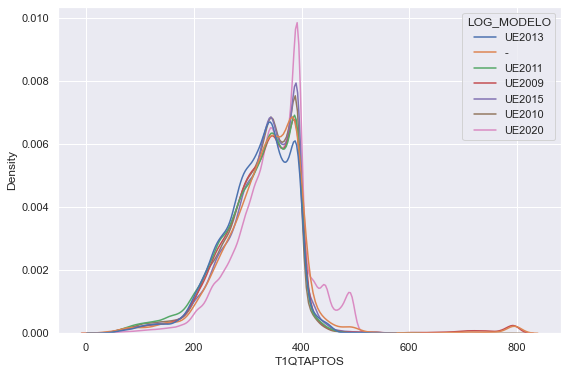

In [ ]:
plt.figure(figsize=(9,6))
sns.kdeplot(data=data,x='T1QTAPTOS',hue='LOG_MODELO',common_norm=False)


# Análise do efeito das maquinas antigas comparadas a nova na mesma região

Máquinas UE2020 são usadas em 1662 zonas eleitorais. Dessas zonas elas são usadas em conjunto com no mínimo 2 máquinas de outros modelos em 713 zonas. Usando teste t vamos ver se existe algum efeito do modelo da máquina nos resultados. Eu sei que o teste t não é válido para o dataset já que a distribuição é claramente não normal, e que não se deve interpretar o valor p rigorosamente, mas gosto de pensar na estatística t apenas como uma métrica de desvio

In [ ]:
collect_a_voto=[]
collect_b_voto=[]
collect_a_turnout=[]
collect_b_turnout=[]
collect_a_apto=[]
collect_b_apto=[]
collect_n=[]
collect_info=[]

municipios=data.loc[data['LOG_MODELO']=='UE2020',['UF','CD_MUNICIPIO', 'NR_ZONA', 'NR_SECAO']]
for i in np.unique(municipios['CD_MUNICIPIO']):
    zonas=municipios.loc[municipios['CD_MUNICIPIO']==i,:]
    
    for j in np.unique(zonas['NR_ZONA']):
        maq_ant=data.loc[np.logical_and(np.logical_and(data['CD_MUNICIPIO']==i,data['NR_ZONA']==j),data['LOG_MODELO']!='UE2020'),['porc lula', 'turnout','T1QTAPTOS']].values
        maq_nova=data.loc[np.logical_and(np.logical_and(data['CD_MUNICIPIO']==i,data['NR_ZONA']==j),data['LOG_MODELO']=='UE2020'),['porc lula', 'turnout','T1QTAPTOS']].values
        
        a,b=ttest_ind(maq_ant[:,0], maq_nova[:,0], axis=0, equal_var=False)
        collect_a_voto.append(a)
        collect_b_voto.append(b)
        a,b=ttest_ind(maq_ant[:,1], maq_nova[:,1], axis=0, equal_var=False)
        collect_a_turnout.append(a)
        collect_b_turnout.append(b)
        a,b=ttest_ind(maq_ant[:,2], maq_nova[:,2], axis=0, equal_var=False)
        collect_a_apto.append(a)
        collect_b_apto.append(b)
        collect_n.append([maq_ant.size,maq_nova.size])
        collect_info.append([i,j,maq_ant,maq_nova])
   

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Primeiro vamos avaliar se ainda existe efietos geográficos em cada zona ou se podemos considerar cada zona decentemente homogênea

Usando p<0.01 como corte estatístico



In [ ]:
b_array=np.asarray(collect_b_turnout)
a_array=np.asarray(collect_a_turnout)
b_val=b_array[np.logical_not(np.isnan(b_array))]
a_val=a_array[np.logical_not(np.isnan(a_array))]
b_dif=b_val<0.01
a_dif=a_val[b_dif]

plt.figure()
sns.kdeplot(a_val)
plt.xlabel('t-value para o turnout')
plt.title('distribuição do desvio de turnout entre urnas antigas e 2020')
print('Sem conclusão {:.3}%'.format((1-np.mean(b_dif))*100))
print('Maquina antiga possui um menor turnout {:.3}% '.format(np.mean(np.logical_and(b_dif,a_val<0))*100))
print('Maquina antiga possui um maior turnout  {:.3}% '.format(np.mean(np.logical_and(b_dif,a_val>0))*100))


In [ ]:
b_array=np.asarray(collect_b_apto)
a_array=np.asarray(collect_a_apto)
b_val=b_array[np.logical_not(np.isnan(b_array))]
a_val=a_array[np.logical_not(np.isnan(a_array))]
b_dif=b_val<0.01
a_dif=a_val[b_dif]

plt.figure()
sns.kdeplot(a_val)
plt.xlabel('t-value para o tamanho das seções')
plt.title('distribuição do t-value entre o tamanho das seções entre urnas antigas e 2020')

print('Sem conclusão {:.3}%'.format((1-np.mean(b_dif))*100))
print('Maquina antiga possui menos eleitores {:.3}% '.format(np.mean(np.logical_and(b_dif,a_val<0))*100))
print('Maquina antiga possui mais eleitores  {:.3}% '.format(np.mean(np.logical_and(b_dif,a_val>0))*100))



In [ ]:
b_array=np.asarray(collect_b_voto)
a_array=np.asarray(collect_a_voto)
b_val=b_array[np.logical_not(np.isnan(b_array))]
a_val=a_array[np.logical_not(np.isnan(a_array))]
b_dif=b_val<0.01

print('Sem conclusão {:.3}%'.format((1-np.mean(b_dif))*100))
print('Maquina antiga favorece o Bolsonaro {:.3}% '.format(np.mean(np.logical_and(b_dif,a_val<0))*100))
print('Maquina antiga favorece o Lula  {:.3}% '.format(np.mean(np.logical_and(b_dif,a_val>0))*100))
plt.figure()
sns.kdeplot(a_val)
plt.xlabel('t-value para o voto em Lula')
plt.title('distribuição do t-value entre voto em Lula entre urnas antigas e 2020')


Existe um certo favorecimento a favor do Lula, mas esse efeito não é consistente e as urnas antigas favorecem Bolsonaro 10% das vezes. É um efeito similar à variação no tamanho das seções.

# conclusão

As diferenças nas distribuições são naturais de um processo real com forte correlação geoespacial como eleições e não são indicativos de fraude. A história que as urnas antes de 2020 favorecem sistematicamente o Lula é falsa